In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE
from jaxtronomy.GaussianRandomField.GRF_fitting import fit_image_function,GRF_Loss_complete

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup (unknown to us)

In [39]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [40]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [41]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [42]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [43]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
#HST PSF for 800 nm wavelength
#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.128}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=100
exp_time=2028
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': exp_time}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

In [44]:
def simulate_perturbed_image(GRF_potential,smooth_kwagrs,perturbed_lens_image,x_coords,y_coords):

  kwargs_lens = smooth_kwagrs['kwargs_lens']+[{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_potential}]

  return perturbed_lens_image.simulation(kwargs_lens=kwargs_lens,
                                        kwargs_source=smooth_kwagrs['kwargs_source'],
                                        kwargs_lens_light=smooth_kwagrs['kwargs_lens_light'])

## Simulate data image

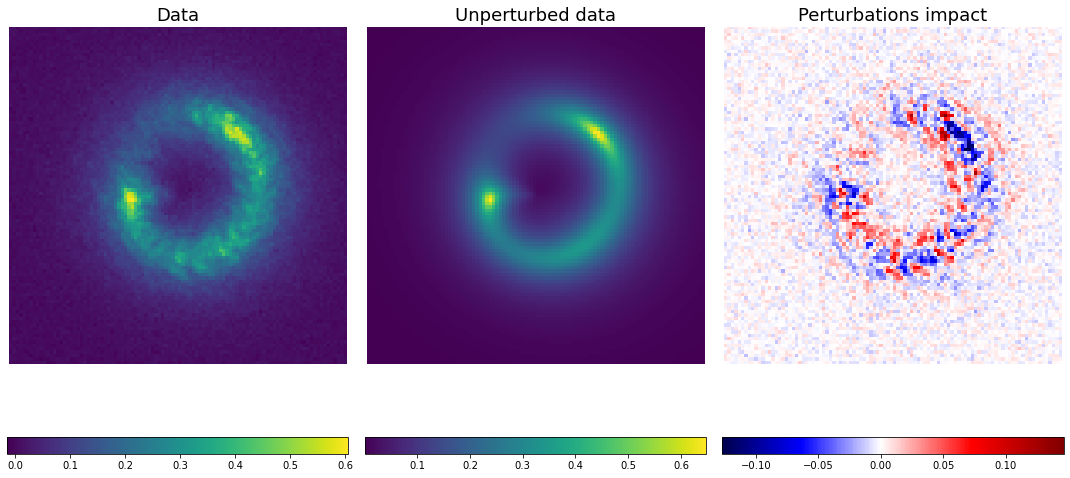

In [45]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)


# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(data_image, origin='lower')
ax[0].set_title("Data", fontsize=FS)


im1=ax[1].imshow(simulate_smooth_image(kwargs_data,smooth_lens_image), origin='lower')
ax[1].set_title("Unperturbed data", fontsize=FS)


im2=ax[2].imshow(data_image-simulate_smooth_image(kwargs_data,smooth_lens_image), origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

# Data preparation

## Fit data to know lens-source kwargs

In [46]:
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


def fit_data(data,lens_image,parameters,method='BFGS'):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method=method, restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

  return kwargs_final

In [47]:
#First guess from priors
kwargs_intermediate={'kwargs_lens': [{'theta_E': 1.5,'e1': 1e-3,'e2': 1e-3,'center_x': 1e-3,'center_y': 1e-3},{'gamma1': 1e-3, 'gamma2': 1e-3, 'ra_0': 0.0, 'dec_0': 0.0}],
                     'kwargs_source': [{'amp': 5.0,'R_sersic': 2.5,'n_sersic': 2.,'center_x': 0.,'center_y': 0.,'e1': 1e-3,'e2': 1e-3}],
                     'kwargs_lens_light': [{}]}

parameters=get_parameters(kwargs_intermediate,lens_mass_model_list,source_light_model_list)
#Get guess of true kwargs
kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
args_guess=parameters.kwargs2args(kwargs_guess)

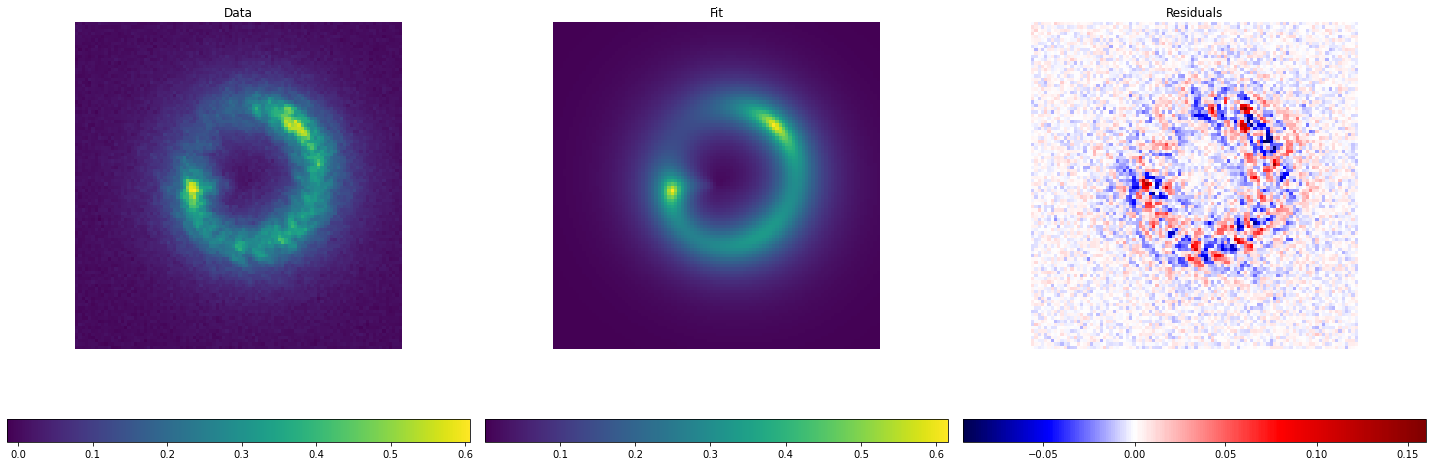

In [48]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(20,7))

im_arr=[]

im=ax[0].imshow(data_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data')

fit_image=smooth_lens_image.model(**kwargs_guess)
im=ax[1].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Fit')

im=ax[2].imshow(data_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals')

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal')
    
fig.tight_layout()
plt.show()

## Einstein ring Mask

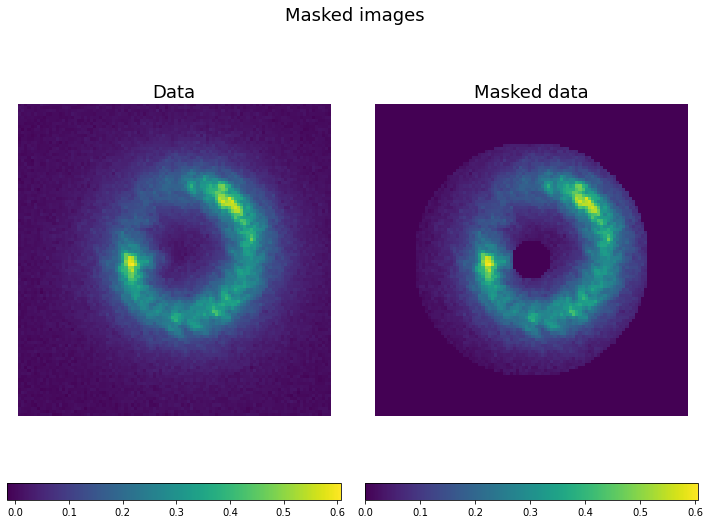

In [49]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(data_image, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(data_image*mask, origin='lower')
ax2.set_title("Masked data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [50]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

## Make the fit

In [51]:
learning_rate=5e-4
max_iter=200

model_loss_function_pure=purify_function(model_loss_function,data_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)

args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
fit_image=smooth_lens_image.model(**parameters.args2kwargs(args_fit))

## Extract spectrum

In [52]:
#Compute Target Power spectrum of data residuals 
data_resid=data_image-fit_image
data_resid_spectrum=compute_radial_spectrum_pure(data_resid)

## Fit spectrum with powerlaw to get Guess of GRF's Power slope

In [53]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,data_resid_spectrum))
GRF_init_guess=np.array(res.x)

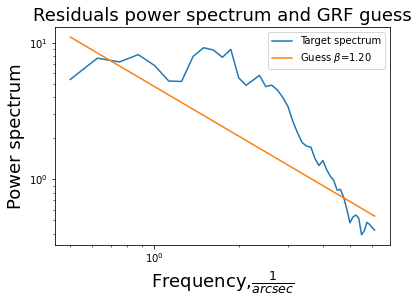

In [54]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,data_resid_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='Guess '+r'$\beta$'+'={:.2f}'.format(GRF_init_guess[1]))
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

# GRF fitting 1 (guess the vicinity)

In [55]:
def perturbations_constraint(GRF_params,Constraint_fraction,GRF_seed,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image):
    
    GRF=get_jaxified_GRF_pure(GRF_params,GRF_seed)
    simulated_image=simulate_perturbed_image_pure(GRF)
    #Residuals with the original fit
    residuals=simulated_image-fit_image
    
    #Perturbations condition
    residuals_fraction=jnp.abs(residuals).max()/fit_image.max()
    
    #residuals are no more than 10% of the unperturbed image
    return Constraint_fraction-residuals_fraction

In [56]:
#We work with MAE and only 1 seed realisation to approach the vicinity of the true GRF parameters

Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,data_resid_spectrum)

GRF_seed_guess=2
#The guessed seed should be different from the true one
assert GRF_seed!=GRF_seed_guess

GRF_Loss_image_fitting_args=(GRF_seed_guess,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

Constraint_fraction=0.2
perturbations_constraint_pure=purify_function(perturbations_constraint,Constraint_fraction,GRF_seed_guess,get_jaxified_GRF_pure,simulate_perturbed_image_pure,fit_image)
#Maximal relation between residuals amplitude and image amplitude that can be called a perturbation

#Optimizer_constraint=NonlinearConstraint(perturbations_constraint_pure,0,Constraint_fraction,jac=jax.jit(perturbations_constraint_pure),hess=jax.jacfwd(jax.jacrev(perturbations_constraint_pure)))


GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [57]:
#%timeit loss_func(GRF_params)
#%timeit grad_loss_func(GRF_params)
#%timeit hess_loss_func(GRF_params)

There are no chances to use hessian in GRF fitting if we fit the lens kwargs inside the loss function.   
Since kwargs fitting is a recursive loop with 100 cycles propagating grads through it becomes very challenging

## Optimization 1

In [58]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=(-10.,GRF_init_guess[1])
bounds=((-15., -5.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,hess=hess_loss_func,bounds=bounds,constraints={'type': 'ineq', 'fun': perturbations_constraint_pure},method='trust-constr',callback=callbackF)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(float64[100,100])>with<DynamicJaxprTrace(level=0/2)>
While tracing the function pure_function at /Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/jaxtronomy/GaussianRandomField/Jax_Utils.py:33 for jit, this concrete value was not available in Python because it depends on the value of the argument 'traced_arg'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [86]:
A_history=[-10.000000,-10.922980,-7.118757,-7.078741,-7.072697,-7.067721,-7.057310,-7.053682,-7.047871,-7.040588,-7.031390,-7.030073,-7.029532,-7.029015,-7.028804,-7.028803]
B_history=[3.980653,5.103964,1.301097,1.362528,1.384602,1.400857,1.422623,1.432909,1.446102,1.463290,1.484720,1.493448,1.494433,1.495747,1.496430,1.496439]

In [98]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/history.npy',np.append([A_history],[B_history],axis=0).T)
#np.save(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/loss_history.npy',loss_history)
#np.save(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/grads_history.npy',grads_history)

In [19]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/history.npy',allow_pickle=True)
#loss_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/loss_history.npy',allow_pickle=True)
#grads_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_1/grads_history.npy',allow_pickle=True)
GRF_guess_1=history[-1]

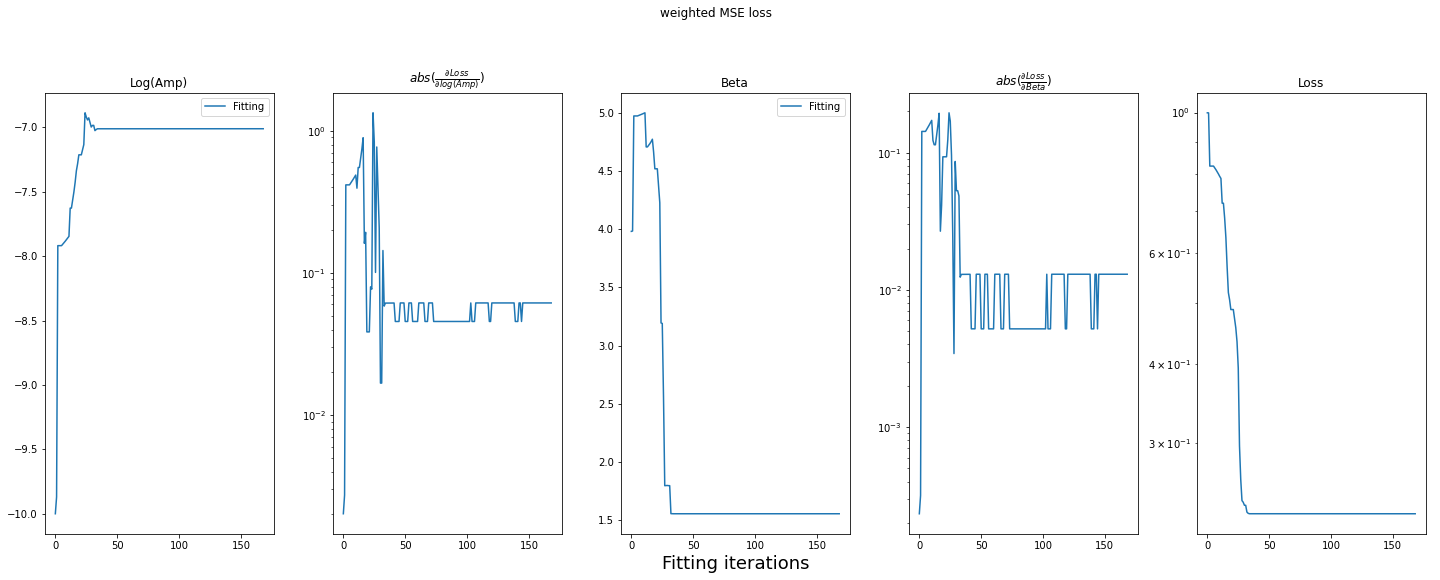

In [32]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
#We don't know the true value
#ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
#We don't know the true value
#ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

# GRF fitting 2 (fine-tune the guess)

## Complete fitting setup

In [45]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,data_resid_spectrum)

Seeds_number=20
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)

fit_image_function_pure=purify_function(fit_image_function,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate)

GRF_Loss_complete_args=(GRF_seeds,get_jaxified_GRF_pure,
                             simulate_perturbed_image_pure,fit_image_function_pure,\
                             compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_complete,*GRF_Loss_complete_args)

#Beta_Loss_pure=jax.jit(lambda Beta: GRF_Loss_pure([GRF_guess_1[0],Beta]))

loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(GRF_Loss_pure))

In [46]:
GRF_Loss_pure(GRF_params)

DeviceArray(0.21079597, dtype=float64)

In [47]:
GRF_Loss_pure(GRF_guess_1)

DeviceArray(0.21404397, dtype=float64)

In [41]:
#%timeit loss_func(GRF_params)
#%timeit grad_loss_func(GRF_params)

In [42]:
#Well, everything seems to be quite bad in terms of optimization speed

## Optimization 2 MSE

In [48]:
Nfeval = 0
history=np.zeros((0,2))
#The values obtained on the previous stage
init_guess=GRF_guess_1
bounds=((-15., -5.), (1., 10.0))

def callbackF(Xi):
    global Nfeval
    global history
    
    print('{0:4d}   {1:3.6f}   {2: 3.6f}'.format(Nfeval, Xi[0], Xi[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,method='Nelder-Mead',callback=callbackF,options={'disp': True})

   0   -7.028803    1.571261
   1   -7.116663    1.524497
   2   -7.116663    1.524497
   3   -7.072733    1.566585
   4   -7.083716    1.518652
   5   -7.097444    1.533558
   6   -7.097444    1.533558
   7   -7.093325    1.514122
   8   -7.101905    1.504732
   9   -7.097529    1.521492
  10   -7.096521    1.513617
  11   -7.099465    1.511143
  12   -7.098225    1.507824
  13   -7.097683    1.511550
  14   -7.098710    1.510415
  15   -7.098182    1.512562
  16   -7.098065    1.511520
  17   -7.098065    1.511520
  18   -7.098270    1.510780
  19   -7.098292    1.511189
  20   -7.098292    1.511189
  21   -7.098292    1.511189
  22   -7.098208    1.511338
  23   -7.098208    1.511338
  24   -7.098208    1.511338
  25   -7.098198    1.511469
  26   -7.098171    1.511508
  27   -7.098196    1.511413
Optimization terminated successfully.
         Current function value: 0.191651
         Iterations: 29
         Function evaluations: 55


In [49]:
np.save(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_2/Nelder_Mead_20phases_history.npy',history)

In [50]:
#history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_2/trustc_nohess_history.npy',allow_pickle=True)
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/Fitting_2/Nelder_Mead_20phases_history.npy',allow_pickle=True)
GRF_fit=history[-1]

In [21]:
Betas_array=np.linspace(0,7,100)
logAmps_array=np.append([-np.inf],np.linspace(-8,-6,99))

#Compute likelihoods for the arrays
logA_likelihood=np.zeros_like(logAmps_array)
Beta_likelihood=np.zeros_like(Betas_array)

#logA_likelihood=jax_map(jax.jit(lambda logA: jnp.exp(-loss_func([logA,GRF_fit[1]])/2)),logAmps_array)
#Beta_likelihood=jax_map(jax.jit(lambda Beta: jnp.exp(-loss_func([GRF_fit[0],Beta])/2)),logAmps_array)

In [52]:
GRF_fit

array([-7.0981962 ,  1.51141336])

In [53]:
'''for i,Beta in tqdm(enumerate(Betas_array)):
    Beta_likelihood[i]=np.exp(-loss_func([GRF_fit[0],Beta])/2)'''

100it [09:51,  5.92s/it]


In [54]:
'''for i,logA in tqdm(enumerate(logAmps_array)):
    logA_likelihood[i]=np.exp(-loss_func([logA,GRF_fit[1]])/2)'''

100it [09:45,  5.86s/it]


In [55]:
#np.save(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/NM_20_logA_likelihood.npy',logA_likelihood)
#np.save(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/NM_20_Beta_likelihood.npy',Beta_likelihood)

In [22]:
logA_likelihood=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/NM_20_logA_likelihood.npy',allow_pickle=True)
Beta_likelihood=np.load(Folder+'Data/Algorithm_test/LogAmp=-7_Beta=2/Constrained_fitting/NM_20_Beta_likelihood.npy',allow_pickle=True)

In [23]:
import scipy 

def gennorm(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.gennorm.pdf(x,s)


def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers where scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
        
    elif distr_func=='gennorm':
        func=gennorm
        init_guess=[1,1.,1.,1]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if np.isin(distr_func,['lognormal','gennorm']):
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier

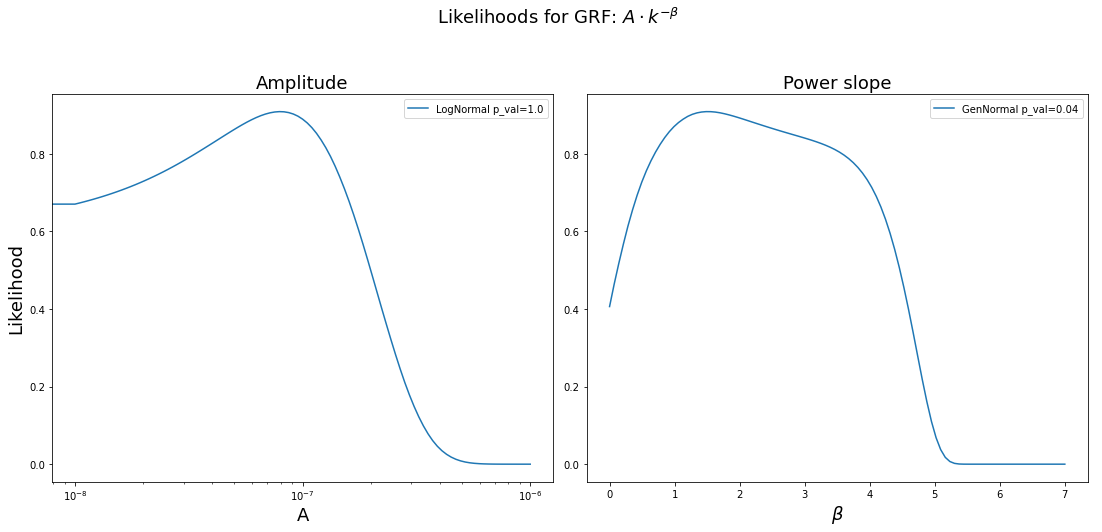

In [24]:
fig,ax=plt.subplots(1,2,figsize=(15,7))

popt=fit_likelihood(np.power(10,logAmps_array),logA_likelihood,distr_func='lognormal',Poisson_errs=False)
y_fit=lognormal(np.power(10,logAmps_array),*popt)

ax[0].plot(np.power(10,logAmps_array),logA_likelihood,label='LogNormal p_val={:.1f}'.format(scipy.stats.ks_2samp(logA_likelihood,y_fit)[1]))
ax[0].hlines
ax[0].set_xscale('log')
ax[0].set_xlabel('A',fontsize=FS)
ax[0].set_title('Amplitude',fontsize=FS)
ax[0].legend()

popt=fit_likelihood(Betas_array,Beta_likelihood,distr_func='gennorm',Poisson_errs=False)
y_fit=gennorm(Betas_array,*popt)

ax[1].plot(Betas_array,Beta_likelihood,label='GenNormal p_val={:.2f}'.format(scipy.stats.ks_2samp(Beta_likelihood,y_fit)[1]))
ax[1].set_xlabel(r'$\beta$',fontsize=FS)
ax[1].set_title('Power slope',fontsize=FS)
ax[1].legend()

fig.suptitle('Likelihoods for GRF: '+r'$A \cdot k^{-\beta}$',fontsize=FS,y=1.05)
fig.tight_layout()  

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#plt.xlabel('Number of phase realisations used',labelpad=20,fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.show()


Text(0.5, 0, 'log(A)')

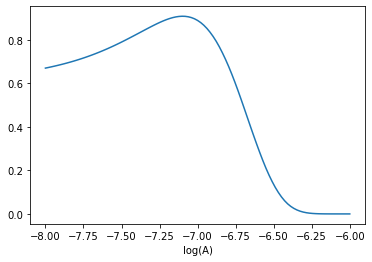

In [25]:
plt.plot(logAmps_array,logA_likelihood)
plt.xlabel('log(A)')
#plt.xticks([])
#plt.yticks([])



In [26]:
def get_cdf(likelihood):
    cdf=np.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]
    
    return normalised_cdf

def get_conf_intervals(xdata,likelihood,center='median',percentage_covered=68.):
    
    cdf=get_cdf(likelihood)
    indent=np.minimum(0.5,percentage_covered/200.)
    
    if center=='median':
        value_index=np.where(cdf>=0.5)[0][0]
    elif center=='max':
        value_index=np.argmax(likelihood)
    else:
        print('wrong center')
        return None
        
    value=xdata[value_index]
    cdf_value=cdf[value_index]
    upper_bound=xdata[np.where(cdf<=cdf_value+indent)[0][-1]]
    lower_bound=xdata[np.where(cdf>=cdf_value-indent)[0][0]]
    
    upper_add=upper_bound-value
    lower_add=value-lower_bound
    return lower_add,value,upper_add

In [27]:
get_conf_intervals(logAmps_array,logA_likelihood,center='median',percentage_covered=68.)

(0.46938775510204067, -7.285714285714286, 0.42857142857142794)

In [28]:
get_conf_intervals(Betas_array,Beta_likelihood,center='median',percentage_covered=68.)

(1.4141414141414141, 2.2626262626262625, 1.4848484848484849)

True values $log(A)=-7$ ,  $\beta=2$


Gaussian likelihood predicts $log(A)=-7.27 ^{+0.43} _{-0.49}$ ,  $\beta=2.48^{+1.56} _{-1.49}$ 